In [105]:
import numpy as np
from matplotlib import pyplot as plt 
import pandas as pd
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
from scipy.spatial import ConvexHull #for plotting rectangles (checking integrals)
import math
from scipy import signal

eV = 1.602e-19 #Joule, electronvolt
h = 6.62607004e-34 #J*s, planck constant
c = 2.99792e8 #m/s', speed of light

# TIMED SEE XPS data (0.05-39.95nm), level 4

In [106]:
df_see_xps = pd.read_csv("/Users/sebastiankalos/Documents/Moondust_new/irradiance_data/timed_see_xps_ssi_l4.csv")
irr_list = []

l=400
for i in range(int(len(df_see_xps)/400)):
    df_day = df_see_xps.iloc[i*l:(i+1)*l]
    wavelength_xps = df_day['wavelength (nm)'].tolist()
    irr = df_day['irradiance (W/m^2/nm)'].tolist()
    irr_list.append(irr)
irr_array = np.array(irr_list)
irradiance_xps = np.nanmedian(irr_array,axis=0) #average of almost 20 years!
irr_xps_stdev = np.nanstd(irr_array,axis=0)

# TIMED SEE lever 3 data (40.5-189.5nm)

In [107]:
df_irr_mid = pd.read_csv("/Users/sebastiankalos/Documents/Moondust_new/irradiance_data/timed_see_ssi_l3.csv") #reading Solar data csv file into a dataframe
df_irr_mid.loc[df_irr_mid['irradiance (W/m^2/nm)'] <0, 'irradiance (W/m^2/nm)'] = np.nan
df_irr_mid = df_irr_mid[df_irr_mid['wavelength (nm)'] >= 40]
irr_list = []
all_days = list(set(df_irr_mid['time (yyyyDDD)'].tolist())) #store all day identifiers and remove duplicates

for day_number in all_days:
    df_day = df_irr_mid[df_irr_mid['time (yyyyDDD)'] == day_number]
    wavelength_mid = df_day['wavelength (nm)'].tolist()
    irr = df_day['irradiance (W/m^2/nm)'].tolist()
    irr_list.append(irr)
irr_array = np.array(irr_list)
irradiance_mid = np.nanmedian(irr_array,axis=0) #average of almost 20 years!
irr_mid_stdev = np.nanstd(irr_array,axis=0)

# SORCE level 3 data (189.5-400nm)

In [108]:
df_irr_near = pd.read_csv("/Users/sebastiankalos/Documents/Moondust_new/irradiance_data/sorce_ssi_l3.csv") #reading Solar data csv file into a dataframe
df_irr_near.loc[df_irr_near['irradiance (W/m^2/nm)'] <0, 'irradiance (W/m^2/nm)'] = np.nan
df_irr_near = df_irr_near[df_irr_near['wavelength (nm)'] > 190]
irr_list = []
all_days = list(set(df_irr_near['time (Julian Date)'].tolist())) #store all day identifiers and remove duplicates
all_days = [ int(x) for x in all_days] #convert all items to integers

for day_number in all_days:
    df_day = df_irr_near[df_irr_near['time (Julian Date)'] == day_number]
    wavelength_near = df_day['wavelength (nm)'].tolist()
    irr = df_day['irradiance (W/m^2/nm)'].tolist()
    irr_list.append(irr)
irr_array = np.array(irr_list)
irradiance_near = np.nanmedian(irr_array,axis=0) #average of almost 20 years!
irr_near_stdev = np.nanstd(irr_array,axis=0)

In [109]:
irradiance = np.concatenate((irradiance_xps, irradiance_mid,irradiance_near))
wavelength = np.concatenate((wavelength_xps, wavelength_mid,wavelength_near))
irr_stdev = np.concatenate((irr_xps_stdev,irr_mid_stdev,irr_near_stdev))

In [110]:
def read_text_file(filename):
    photon_E, total_yield, yield_error = [],[],[]
    copy_lines=[]
    with open(filename) as f:
        lines = f.readlines()
    for line in lines:
        split_line = line.split()
        copy_lines.append(split_line)
    #from each line, extract a name/number and append it into its relevant column
    for i in range(1,len(copy_lines)-1): #2nd line in the file is the first relevant one
        line = copy_lines[i]
        photon_E.append(float(line[0])) #strip element name and type of commas
        total_yield.append(float(line[1]))
        yield_error.append(float(line[2]))
    return([np.array(photon_E), np.array(total_yield), np.array(yield_error)])

In [111]:
[Au_full_E, Au_full_TEY, Au_full_TEY_err] = read_text_file('TEY_files/Au_full_yield.txt')
[Mg_alloy_full_E, Mg_alloy_full_TEY, Mg_alloy_full_TEY_err] = read_text_file('TEY_files/Mg_alloy_full_yield.txt')
[Aerodag_full_E, Aerodag_full_TEY, Aerodag_full_TEY_err] = read_text_file('TEY_files/Aerodag_full_yield.txt')
[Graphite_full_E, Graphite_full_TEY, Graphite_full_TEY_err] = read_text_file('TEY_files/Graphite_full_yield.txt')
[Coverglass_full_E, Coverglass_full_TEY, Coverglass_full_TEY_err] = read_text_file('TEY_files/Coverglass_full_yield_NORM.txt')
[Ag_full_E, Ag_full_TEY, Ag_full_TEY_err] = read_text_file('TEY_files/Ag_full_yield_NORM.txt')
[Ti_full_E, Ti_full_TEY, Ti_full_TEY_err] = read_text_file('TEY_files/Ti_full_yield_NORM.txt')
[ITO_MLI_aug22_full_E, ITO_MLI_aug22_full_TEY, ITO_MLI_aug22_full_TEY_err] = read_text_file('TEY_files/ITO_MLI_aug22_full_yield_NORM.txt')

In [347]:
def ion_cutoff(E_vals=list, TEY_vals=list,TEY_err_vals=list,name=str,stop_noise_eV=float,start_eV=float,stop_eV=float,noise_override=float):
    if stop_noise_eV>=start_eV:
        print('invalid eV interval chosen')
        return
    plt.plot(E_vals,TEY_vals,'--.',linewidth=1,label='yield data')
    plt.fill_between(E_vals,TEY_vals+TEY_err_vals, TEY_vals-TEY_err_vals, alpha=0.3, joinstyle='round')
    plt.yscale('log')
    plt.xlim(3,15)

    x,y,noise=[],[],[]
    for xval,yval in zip(E_vals, TEY_vals):
        if xval>=start_eV and xval<=stop_eV:
            x.append(xval)
            y.append(yval)
        elif xval<stop_noise_eV:
            noise.append(yval)
    # extract intervals for linear regression, (reshape required!) and plot them over
    x = np.array(x).reshape((-1, 1))
    y = np.array(y)
    if noise_override==0:
        noise_lvl = np.mean(noise)
    else:
        noise_lvl=noise_override
    plt.plot(x, y,'.', color = 'orange', label='data taken for regression')
    # linear regression
    model = LinearRegression().fit(x, np.log(y))
    ion_cutoff = (np.log(noise_lvl)-model.intercept_)/model.coef_ #get x-intercept (cutoff) from slope and y-intercept

    x_vals = np.linspace(ion_cutoff[0],stop_eV,100) #get x-values for plotting the found regression
    y_vals = np.exp(model.coef_*x_vals+model.intercept_) #get y vales of the linear regression

    new_E_vals = list(x_vals) #initialize an array for a new ph.energy data, using the regression for low energy values
    new_TEY_vals = list(y_vals) #initialize an array for a new YIELD data, using the regression for low energy values
    for E_val,TEY_val in zip(E_vals,TEY_vals):
        if E_val > x_vals[-1]: #starting at the highest photon energy from the regression, append from the original
            new_E_vals.append(E_val)
            new_TEY_vals.append(TEY_val)

    plt.plot(x_vals,y_vals,label='regression')
    plt.vlines(x = ion_cutoff[0],ymin=0,ymax=noise_lvl,color='purple')
    plt.text(s='ionization\ncutoff = {:0.2f} eV'.format(ion_cutoff[0]), x=ion_cutoff[0]+0.1, y=0.1*noise_lvl,color='purple')
    plt.hlines(y = noise_lvl,xmin=3,xmax=ion_cutoff[0],color='black',linestyle='--')
    plt.text(s='noise level', x=3.1, y=1.1*noise_lvl)

    plt.xlabel('photon energy [eV]')
    plt.ylabel('yield')
    plt.legend()
    plt.title(name)
    plt.ylim(1e-7,1)
    plt.grid(which = 'major', linestyle='-',color='0.85')
    plt.grid(which = 'minor', linestyle='--', color='0.85')
    plt.savefig(f"plots/ion_thresh_"+name+".png", bbox_inches='tight', dpi=300)

    return [round(ion_cutoff[0],2),new_E_vals,new_TEY_vals]

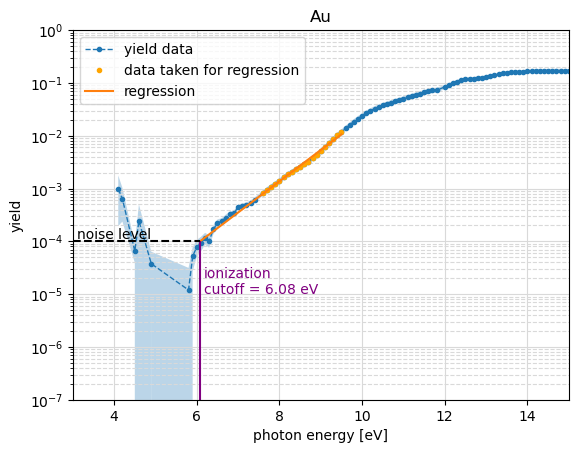

In [348]:
Au_ion_thresh,Au_E_NEW,Au_TEY_NEW = ion_cutoff(E_vals=Au_full_E, TEY_vals=Au_full_TEY,TEY_err_vals=Au_full_TEY_err,name='Au',stop_noise_eV=5.5,start_eV=7.5,stop_eV=9.5,noise_override=1e-4)

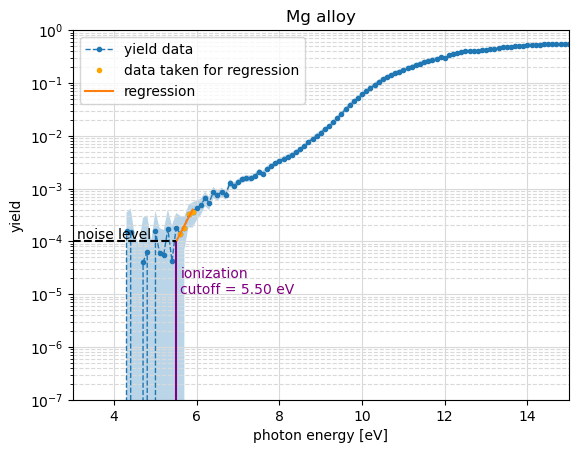

In [350]:
Mg_alloy_ion_thresh,Mg_alloy_E_NEW,Mg_alloy_TEY_NEW = ion_cutoff(E_vals=Mg_alloy_full_E, TEY_vals=Mg_alloy_full_TEY,TEY_err_vals=Mg_alloy_full_TEY_err,name='Mg alloy',stop_noise_eV=5,start_eV=5.5,stop_eV=5.9,noise_override=1e-4)

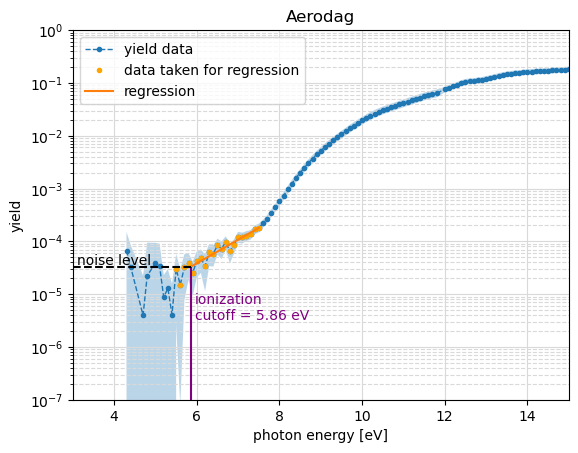

In [351]:
Aerodag_ion_thresh,Aerodag_E_NEW,Aerodag_TEY_NEW=ion_cutoff(E_vals=Aerodag_full_E, TEY_vals=Aerodag_full_TEY,TEY_err_vals=Aerodag_full_TEY_err,name='Aerodag',stop_noise_eV=5,start_eV=5.5,stop_eV=7.5,noise_override=0)

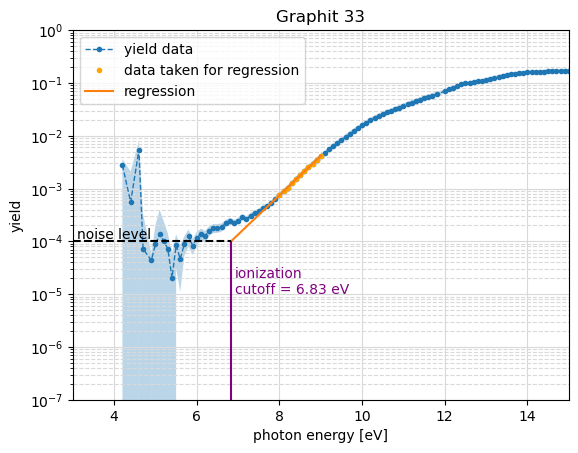

In [352]:
Graphite_ion_thresh,Graphite_E_NEW,Graphite_TEY_NEW=ion_cutoff(E_vals=Graphite_full_E, TEY_vals=Graphite_full_TEY,TEY_err_vals=Graphite_full_TEY_err,name='Graphit 33',stop_noise_eV=6,start_eV=8,stop_eV=9,noise_override=1e-4)

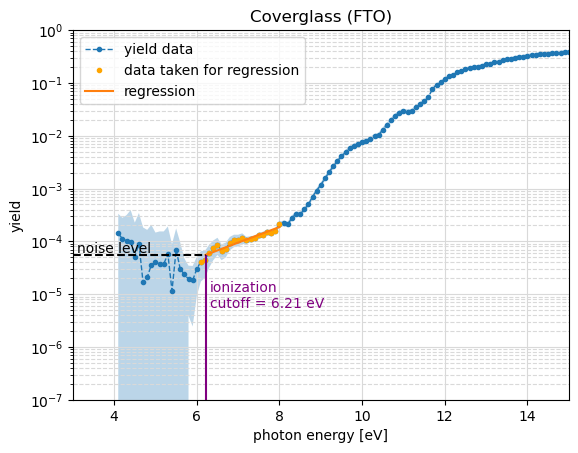

In [353]:
Coverglass_ion_thresh,Coverglass_E_NEW,Coverglass_TEY_NEW=ion_cutoff(E_vals=Coverglass_full_E, TEY_vals=Coverglass_full_TEY,TEY_err_vals=Coverglass_full_TEY_err,name='Coverglass (FTO)',stop_noise_eV=5.9,start_eV=6,stop_eV=8,noise_override=0)

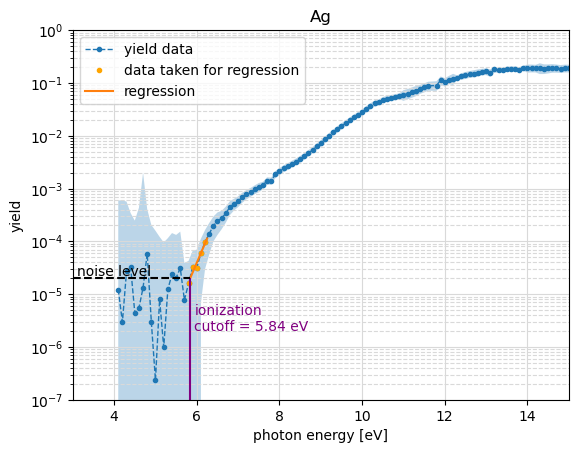

In [354]:
Ag_ion_thresh,Ag_E_NEW,Ag_TEY_NEW=ion_cutoff(E_vals=Ag_full_E, TEY_vals=Ag_full_TEY,TEY_err_vals=Ag_full_TEY_err,name='Ag',stop_noise_eV=5.7,start_eV=5.8,stop_eV=6.25,noise_override=2e-5)

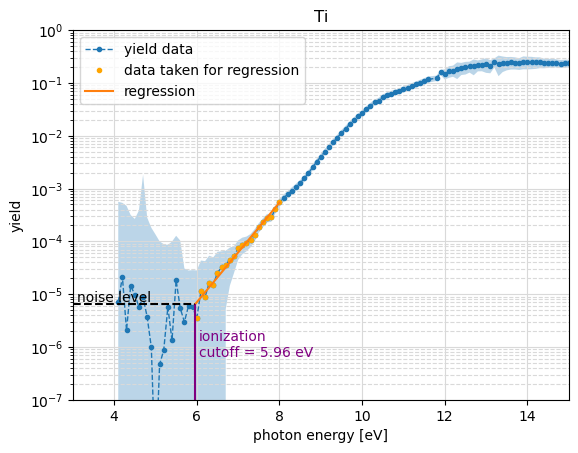

In [355]:
Ti_ion_thresh,Ti_E_NEW,Ti_TEY_NEW=ion_cutoff(E_vals=Ti_full_E, TEY_vals=Ti_full_TEY,TEY_err_vals=Ti_full_TEY_err,name='Ti',stop_noise_eV=5.8,start_eV=6,stop_eV=8,noise_override=0)

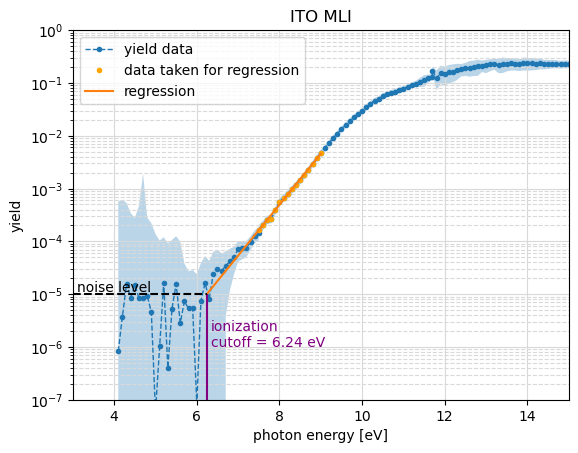

In [356]:
ITO_ion_thresh,ITO_E_NEW,ITO_TEY_NEW=ion_cutoff(E_vals=ITO_MLI_aug22_full_E, TEY_vals=ITO_MLI_aug22_full_TEY,TEY_err_vals=ITO_MLI_aug22_full_TEY_err,name='ITO MLI',stop_noise_eV=5.8,start_eV=7.5,stop_eV=9,noise_override=1e-5)

In [275]:
def convert_eV_to_nm(energy_eV_list):
    # a simple function that takes a list with photon energy values (in eV) and converts them into wavelength (in nm)
    wavelength_list = []
    for datapoint in energy_eV_list:
        energy_J = datapoint * eV
        wavelength_list.append(h*c/energy_J*1e9) #in nm
    return(wavelength_list)

In [276]:
def split_by_nm(eV_list=list,TEY_list=list,thresholds_nm=list):
    nm_list = convert_eV_to_nm(eV_list) #convert list of photon energies to nm
    start_nm = thresholds_nm[0] 
    stop_nm = thresholds_nm[1]
    def condition(x, start, stop): return (x >= start and x<stop)
    output = [idx for idx, element in enumerate(nm_list) if condition(element,start_nm,stop_nm)]
    picked_nm = [nm_list[ind] for ind in output]
    picked_TEY = [TEY_list[ind] for ind in output]
    return [picked_nm,picked_TEY]

def split_to_fit(eV_list=list,TEY_list=list,nm_limits=list,orders=list):
    fits = []
    for i in range(len(nm_limits)-1): #there only are n-1 gaps between n trees!
        start = nm_limits[i] 
        stop = nm_limits[i+1]
        [nm,tey] = split_by_nm(eV_list=eV_list,TEY_list=TEY_list,thresholds_nm=[start,stop])
        fit = np.poly1d(np.polyfit(nm, tey, orders[i]))
        fits.append(fit)
    return fits

In [277]:
import warnings
warnings.filterwarnings('ignore')# just to get rid of annoying texts being printed in output

In [340]:
def integrate_J(eV_list=list,TEY_list=list,TEY_err_list=list,irradiance_stdev=list,name=str,ion_threshold_eV=float):
    ion_thresh_nm = convert_eV_to_nm([ion_threshold_eV])[0] #convert inonization threshold to nm
    #wavelengths (nm) at which yield data shall be split into regions (for polynomial fitting):

    if ion_thresh_nm>190:
        lims =   [1 , 5 , 10 , 25 , 50 , 100 , 120, 160, 190,ion_thresh_nm] #delimitiations of wavelength regions into which the yield will be split (for plynomial fitting)
        orders = [ 15, 15,  15,  15,   15,  15,   10,   3,  3]#each polynomial fit needs to have an order specified
    else:
        lims =   [1 , 5 , 10 , 25 , 50 , 100 , 120, 160,ion_thresh_nm]
        orders = [ 15, 15,  15,  15,   15,  15,   10,   3]

    fig, ax1 = plt.subplots(figsize=(14, 5), dpi=100)#initialize a plot
    ax2 = ax1.twinx()#make a dual y-axis
    ax1.plot(convert_eV_to_nm(eV_list),TEY_list,'.',markersize=1,label=name)#plot yield data vs wavelength in nm
    ax1.axvline(x=ion_thresh_nm,color='purple') #plot a vertical line with the ionization threshold, and print an accompanying text
    ax1.text(s='ionization threshold\n{:0.1f} nm = {:0.2f} eV'.format(ion_thresh_nm,ion_threshold_eV),x=ion_thresh_nm+2,y=0.1,color='purple')
    ax1.set_yscale('log')
    ax1.set_xlim(0,ion_thresh_nm+40)
    ax1.set_ylabel('yield')

    fits = split_to_fit(eV_list=eV_list,TEY_list=TEY_list,nm_limits=lims,orders=orders) #find the polynomial fits to yield
    err_fits = split_to_fit(eV_list=eV_list,TEY_list=TEY_err_list,nm_limits=lims,orders=orders)

    regs = []
    for i in range(len(lims)-1):
        reg = np.linspace(lims[i],lims[i+1],1000)
        regs.append(reg)

    for nm,fit in zip(regs,fits): #plot polynomial fits to the yield (just to check, and)
        tey = fit(nm) #yield of that region is the wavelength region run through the generated polynomial fit
        ax1.plot(nm,tey)

########################################################
    #[nm,flux] = el_flux(wavelength,irradiance,lims,fits)
    J=0 #initial current density before the integral is performed
    if True:
        spectral_flux,spectral_flux_err,used_lambda = [],[],[]

        for i in range(len(wavelength)):
            if i+1<len(wavelength):
                d_nm=(wavelength[i+1]-wavelength[i])

            lambda_val=wavelength[i]
            irr_val=irradiance[i]
            flag = 0 #is the region of interest found (split into regions due to polynomial fitting of yield data)
            for l in range(len(lims)-1): #find the proper region (again, #of regions is one minus the number of limits)
                if lambda_val >= lims[l] and lambda_val < lims[l+1]:
                    current_reg = l #save the order number of the polyfit region in which the wavelength is located
                    flag  = 1

            if flag: #if the region is indeed found
                fit = fits[current_reg] #fit takes in wavelength in nm, not m!

                spectral_flux_val = fit(lambda_val)*irr_val*(lambda_val*1e-9)/(h*c) # * d_lambda only in the full integral, not spectrum!
                spectral_flux.append(spectral_flux_val)
                used_lambda.append(lambda_val)

                err_fit = err_fits[current_reg]
                dY = err_fit(lambda_val)
                dF = irradiance_stdev[i]
                spectral_flux_val_err = 1/(h*c)*np.sqrt((irr_val*lambda_val*1e-9*dY)**2 + (fit(lambda_val)*lambda_val*1e-9*dF)**2 + (fit(lambda_val)*irr_val*d_nm*1e-9)**2)
                spectral_flux_err.append(spectral_flux_val_err)
                spectral_J_err=spectral_flux_err*eV

                if math.isnan(spectral_flux_val):
                    #print("problem with spectral flux value at {:.0f} nm".format(lambda_val))
                    continue
                else:
                    if math.isnan(lambda_val):
                        print("problem with lambda value")
                    else:
                        pts1 = [[lambda_val-d_nm/2, 0], [lambda_val-d_nm/2, spectral_flux_val*eV], [lambda_val+d_nm/2, 0.0], [lambda_val+d_nm/2, spectral_flux_val*eV]]
                        pts = np.array(pts1)
                        hull = ConvexHull(pts)
                        ax2.fill(pts[hull.vertices,0], pts[hull.vertices,1],'red',alpha=0.5)

                        J+=spectral_flux_val*eV*d_nm #d_nm, not d_nm*1e-9 (irradiance by nm already, not by m)

        
        nm=np.array(used_lambda)
        flux=np.array(spectral_flux)

    ax1.text(x=70,y=1e-4,s='J = {:.1f} uA/m^2'.format(J*1e6),fontsize=15)

########################################################


    ax2.plot(nm,flux*eV,'.',color='black',linestyle='-',markersize=1,linewidth=1)
    ax2.set_ylabel('spectral current density [A/(m^2*nm)]')

    ax2.set_yscale('log')
    plt.title(name)

    ax3 = ax1.twiny()
    new_eV_ticks=[5,6,7,8,9,10,12,15,20,30,40,60,100,1500]
    new_tick_locations = np.array(convert_eV_to_nm(new_eV_ticks))
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xticks(new_tick_locations)
    ax3.set_xticklabels(new_eV_ticks)
    ax3.set_xlabel('photon energy [eV]',size=12)

    print('Current density: {:.1f} uA/m^2'.format(J*1e6))

    return round(J*1e6,2),spectral_J_err #return current density in microamps/m^2, rounded to two decimals


IndexError: index 773 is out of bounds for axis 0 with size 773

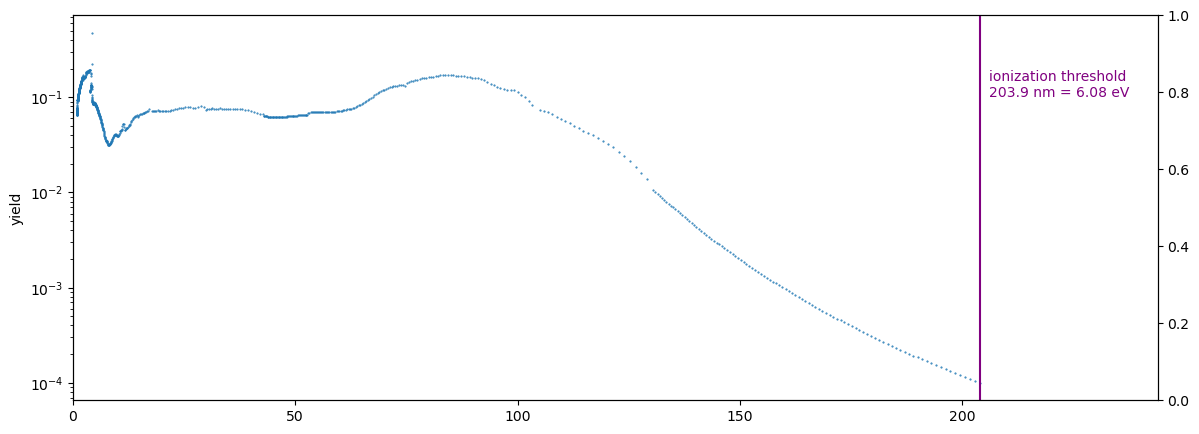

In [341]:
[Au_J,Au_J_spect_err]=integrate_J(eV_list=Au_E_NEW,TEY_list=Au_TEY_NEW,TEY_err_list=Au_full_TEY_err,irradiance_stdev=irr_stdev,name='Au',ion_threshold_eV=Au_ion_thresh)

Current density: 147.2 uA/m^2


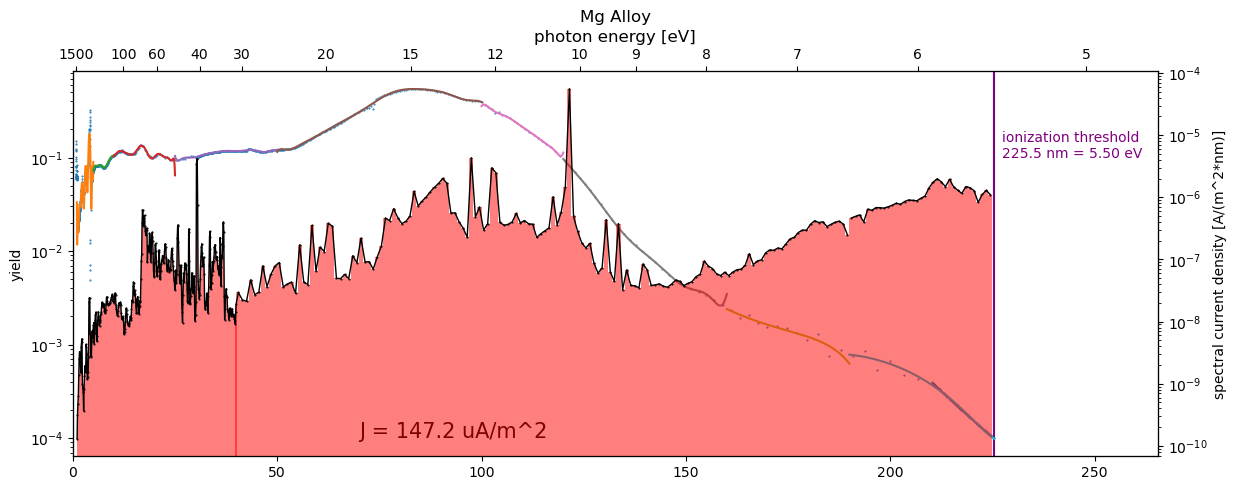

In [313]:
Mg_alloy_J=integrate_J(eV_list=Mg_alloy_E_NEW,TEY_list=Mg_alloy_TEY_NEW,name='Mg Alloy',ion_threshold_eV=Mg_alloy_ion_thresh)

Current density: 34.4 uA/m^2


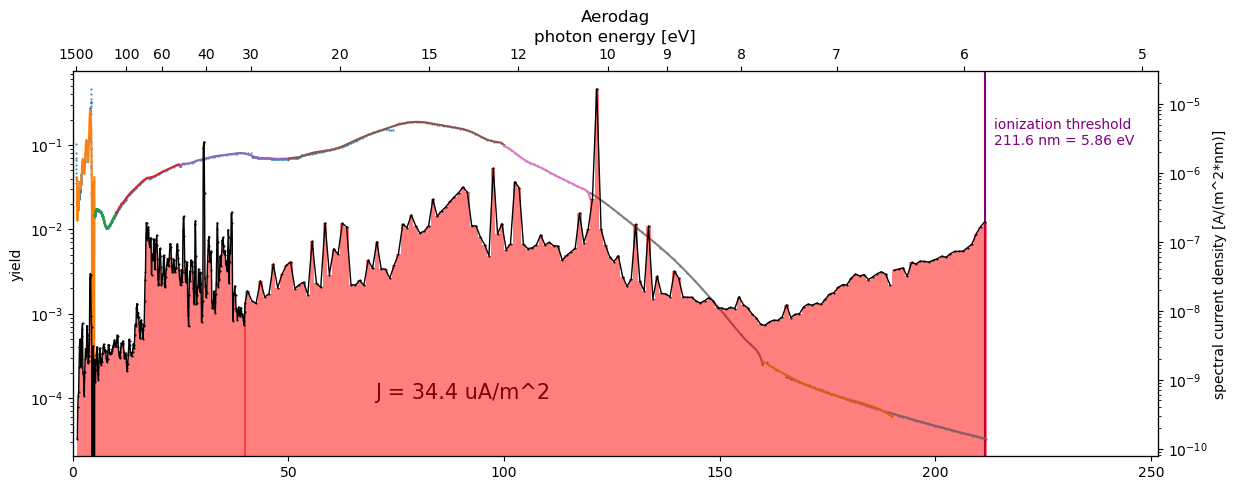

In [281]:
Aerodag_J=integrate_J(eV_list=Aerodag_E_NEW,TEY_list=Aerodag_TEY_NEW,name='Aerodag',ion_threshold_eV=Aerodag_ion_thresh)

Current density: 28.7 uA/m^2


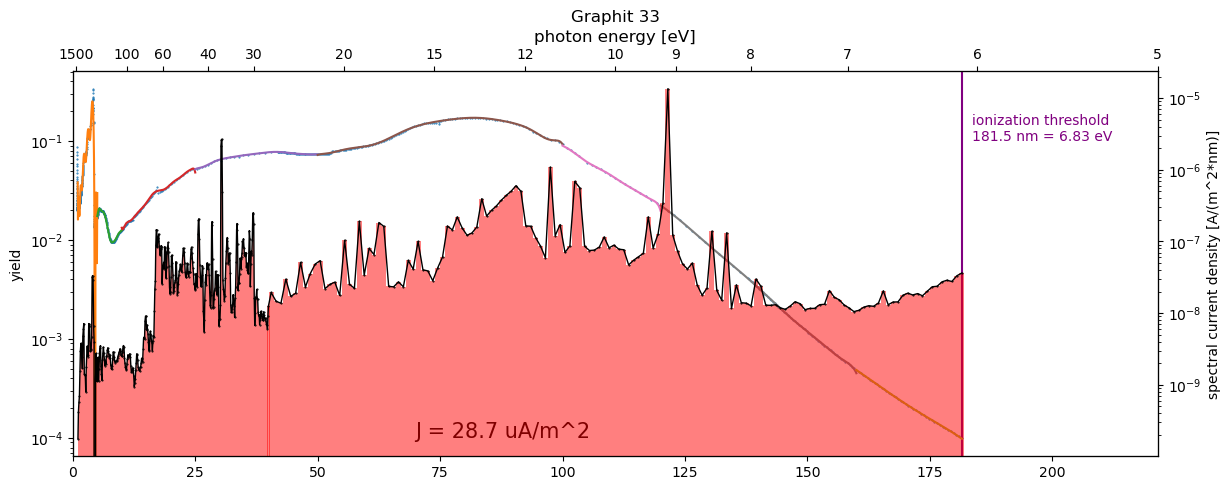

In [282]:
Graphite_J=integrate_J(eV_list=Graphite_E_NEW,TEY_list=Graphite_TEY_NEW,name='Graphit 33',ion_threshold_eV=Graphite_ion_thresh)

Current density: 36.4 uA/m^2


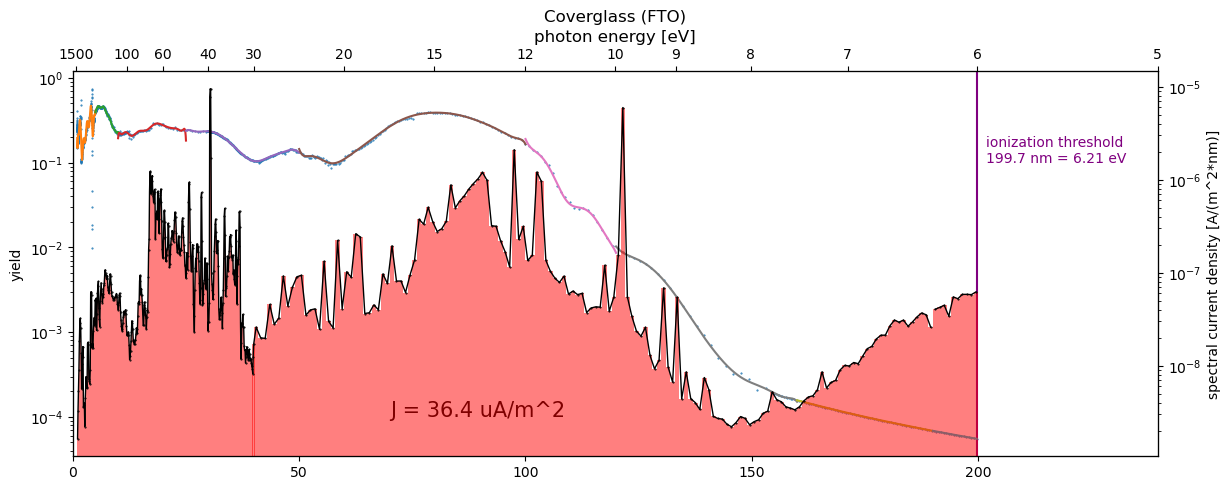

In [283]:
Coverglass_J=integrate_J(eV_list=Coverglass_E_NEW,TEY_list=Coverglass_TEY_NEW,name='Coverglass (FTO)',ion_threshold_eV=Coverglass_ion_thresh)

Current density: 50.7 uA/m^2


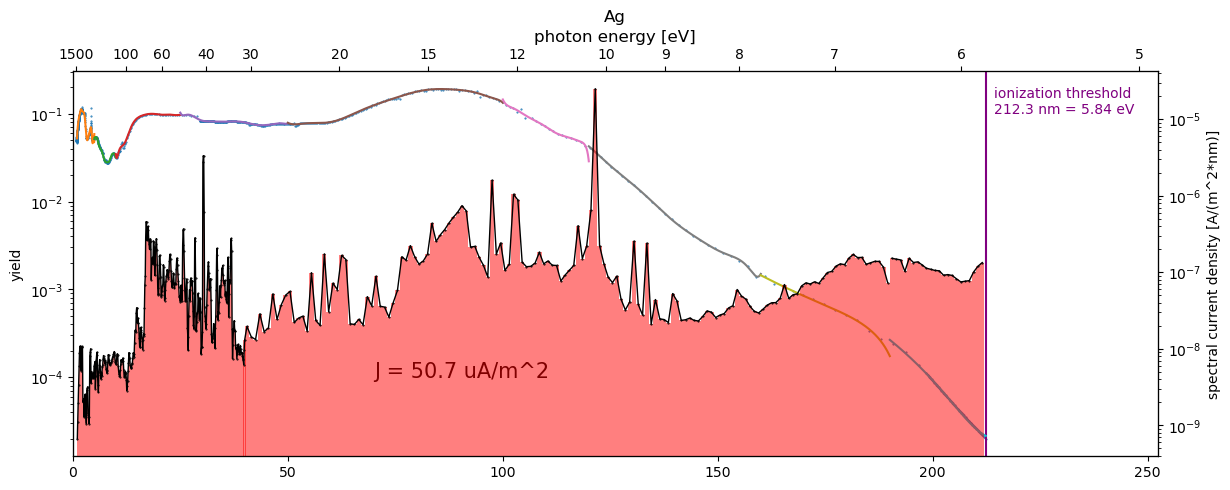

In [319]:
Ag_J=integrate_J(eV_list=Ag_E_NEW,TEY_list=Ag_TEY_NEW,name='Ag',ion_threshold_eV=Ag_ion_thresh)

Current density: 49.9 uA/m^2


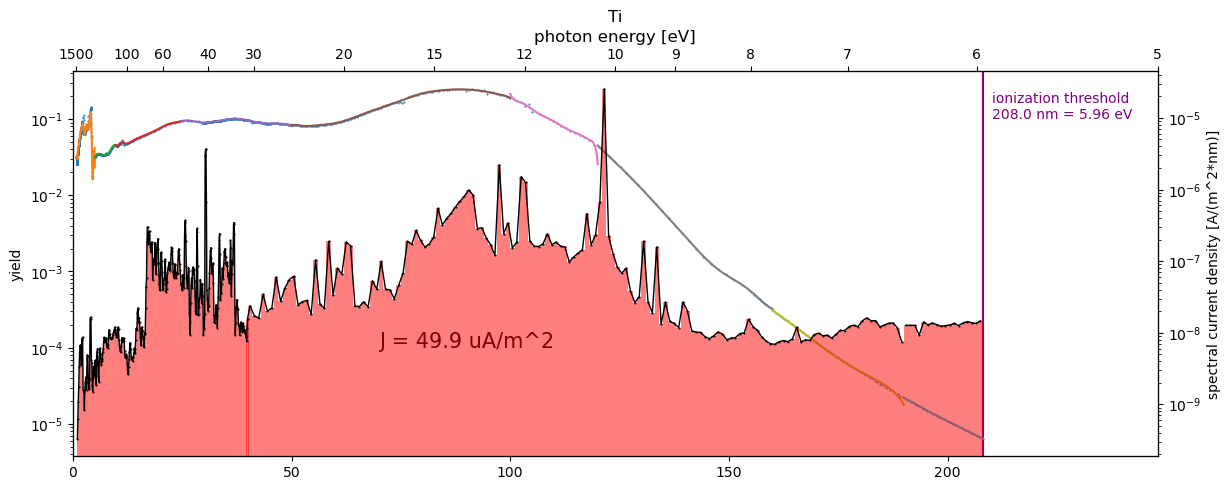

In [298]:
Ti_J=integrate_J(eV_list=Ti_E_NEW,TEY_list=Ti_TEY_NEW,name='Ti',ion_threshold_eV=Ti_ion_thresh)

Current density: 52.7 uA/m^2


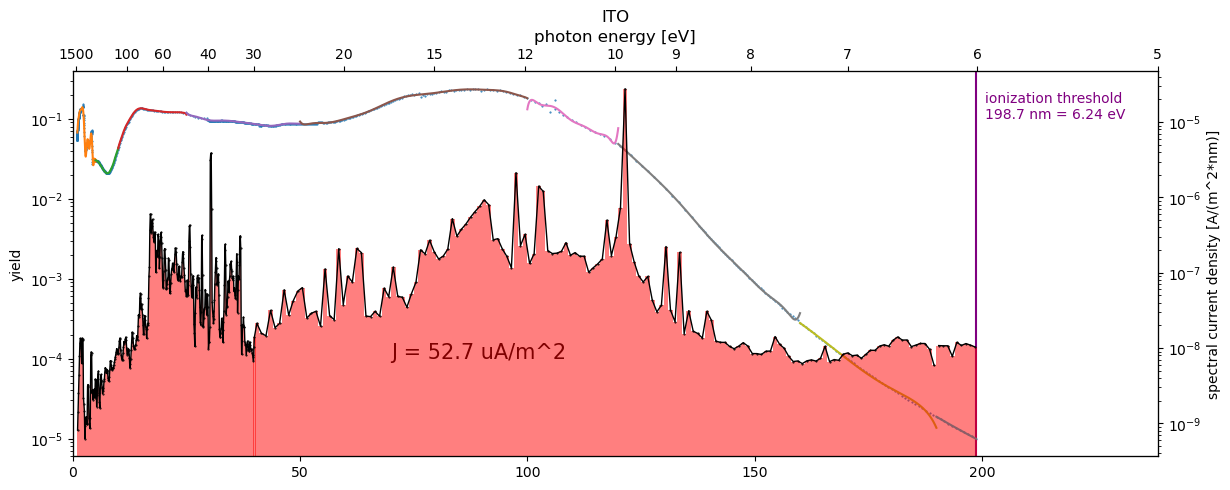

In [286]:
ITO_J=integrate_J(eV_list=ITO_E_NEW,TEY_list=ITO_TEY_NEW,name='ITO',ion_threshold_eV=ITO_ion_thresh)

In [287]:
def harm_smooth(data=list,n=int): #function defining a harmonic average smoothing
    for i in range(len(data)-n):
        sublist=data[i:i+n]#take a subarray of data of n elements
        sum=0
        for val in sublist:
            sum+=1/val
    print(sublist)
    return 1/sum

In [288]:
data=[1,2,3,4,5,6,7,8,9]
harm_smooth(data=data,n=3)

[6, 7, 8]


2.3013698630136985

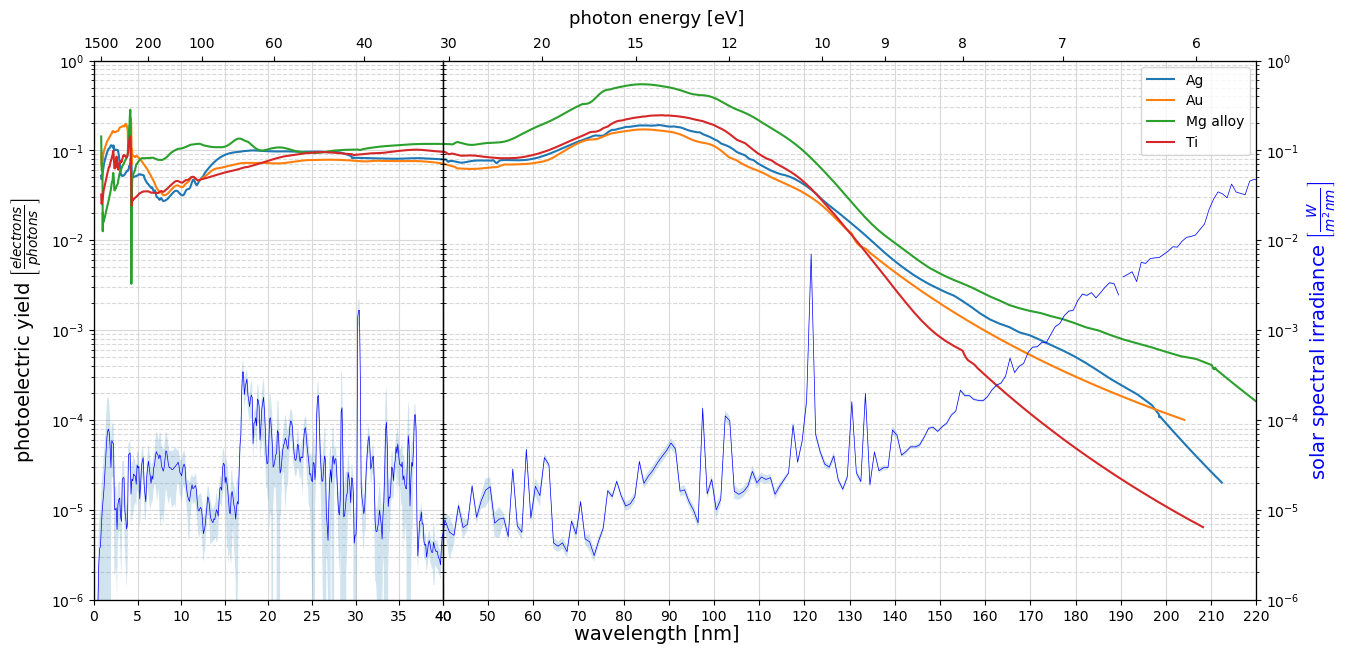

In [337]:
import matplotlib.gridspec as gridspec

plt.figure(figsize = (15,7),dpi=100)
gs = gridspec.GridSpec(1, 10)
gs.update(wspace=0.0, hspace=0.00) # set the spacing between axes. 

marker='.'
markersize=1
linewidth = 0.5
linestyle='none'
alpha=0.2
joinstyle='round'

ax1 = plt.subplot(gs[0,:3])
ax2 = plt.subplot(gs[0,3:])

ax3 = ax1.twinx()
ax3.plot(wavelength,irradiance,color='blue',linewidth=0.5,label='Solar\nIrradiance')
ax3.fill_between(wavelength, irradiance+irr_stdev, irradiance-irr_stdev, alpha=alpha, joinstyle=joinstyle)

ax4 = ax2.twinx()
ax4.plot(wavelength,irradiance,color='blue',linewidth=0.5,label='Solar\nIrradiance')
ax4.fill_between(wavelength, irradiance+irr_stdev, irradiance-irr_stdev, alpha=alpha, joinstyle=joinstyle)

ax1.plot(convert_eV_to_nm(Ag_E_NEW),signal.savgol_filter(Ag_TEY_NEW,9,5),'-',markersize=1)
ax2.plot(convert_eV_to_nm(Ag_E_NEW),signal.savgol_filter(Ag_TEY_NEW,9,5),'-',markersize=1,label='Ag')

ax1.plot(convert_eV_to_nm(Au_E_NEW),signal.savgol_filter(Au_TEY_NEW,17,5),'-',markersize=1)
ax2.plot(convert_eV_to_nm(Au_E_NEW),signal.savgol_filter(Au_TEY_NEW,17,5),'-',markersize=1,label='Au')

ax1.plot(convert_eV_to_nm(Mg_alloy_E_NEW),signal.savgol_filter(Mg_alloy_TEY_NEW,17,5),'-',markersize=1)
ax2.plot(convert_eV_to_nm(Mg_alloy_E_NEW),signal.savgol_filter(Mg_alloy_TEY_NEW,17,5),'-',markersize=1,label='Mg alloy')

ax1.plot(convert_eV_to_nm(Ti_E_NEW),signal.savgol_filter(Ti_TEY_NEW,17,5),'-',markersize=1)
ax2.plot(convert_eV_to_nm(Ti_E_NEW),signal.savgol_filter(Ti_TEY_NEW,17,5),'-',markersize=1,label='Ti')

x_stop = 220
ax1.set_xlim(0,40)
ax2.set_xlim(40,x_stop)

ax1.set_ylim([1e-6,1])
ax2.set_ylim([1e-6,1])
ax3.set_ylim([1e-6,1])
ax4.set_ylim([1e-6,1])
ax1.set_yscale("log")
ax2.set_yscale("log")
ax3.set_yscale('log')
ax4.set_yscale('log')

plt.figtext(0.5, 0.06, 'wavelength [nm]', ha='center', va='center',size=14)
plt.figtext(0.5, 0.94, 'photon energy [eV]', ha='center', va='center',size=13)
ax1.set_ylabel(r"photoelectric yield $\left[\frac{electrons}{photons}\right]$",size=14)
ax1.grid(which = 'major', linestyle='-',color='0.85')
ax1.grid(which = 'minor', linestyle='--', color='0.85')

ax2.grid(which = 'major', linestyle='-',color='0.85')
ax2.grid(which = 'minor', linestyle='--', color='0.85')
ax2.set_xticks(np.arange(40,x_stop+1,10))
ax2.set_yscale('log')

ax2.set_yticks([])
ax3.set_yticks([])

ax6 = ax2.twiny()
new_eV_ticks=[6,7,8,9,10,12,15,20,30]
new_tick_locations = np.array(convert_eV_to_nm(new_eV_ticks))
ax6.set_xlim(ax2.get_xlim())
ax6.set_xticks(new_tick_locations)
ax6.set_xticklabels(new_eV_ticks)

ax5 = ax1.twiny()
new_eV_ticks=[40,60,100,200,1500]
new_tick_locations = np.array(convert_eV_to_nm(new_eV_ticks))
ax5.set_xlim(ax1.get_xlim())
ax5.set_xticks(new_tick_locations)
ax5.set_xticklabels(new_eV_ticks)

ax2.legend()

ax4.set_ylabel(r"solar spectral irradiance $\left[\frac{W}{m^2 nm}\right]$",color='blue',size=14)

plt.savefig('plots/metals_ion_threshs.png', bbox_inches='tight', dpi=300)

# Comparison of smoothened curves with the original ones:

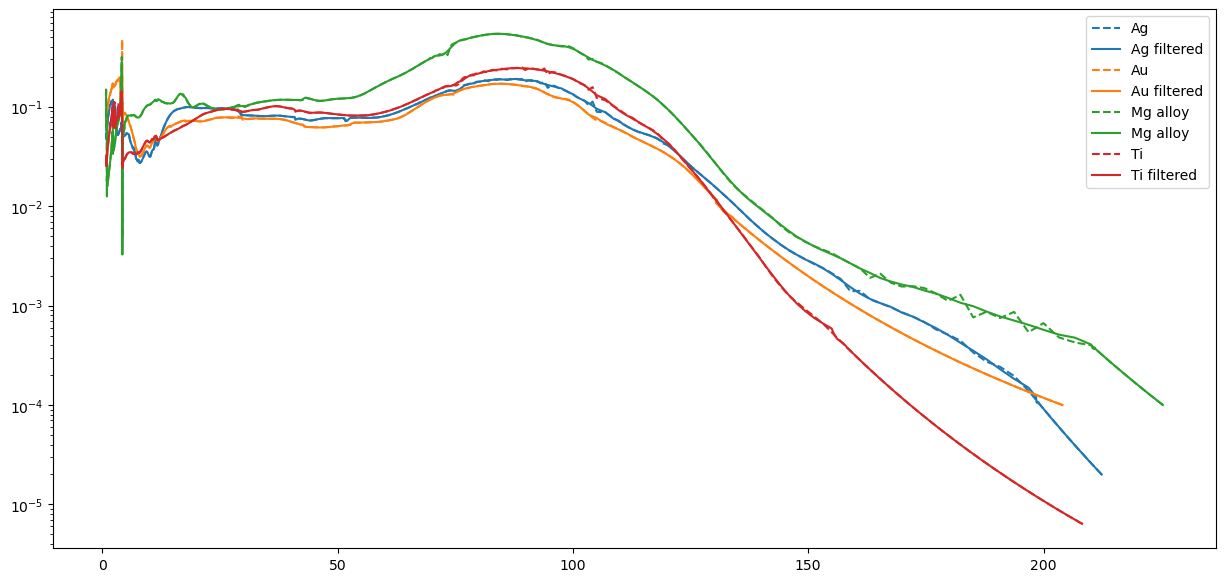

In [338]:

plt.figure(figsize = (15,7),dpi=100)
plt.plot(convert_eV_to_nm(Ag_E_NEW),Ag_TEY_NEW,'--',color='tab:blue',label='Ag')
plt.plot(convert_eV_to_nm(Ag_E_NEW),signal.savgol_filter(Ag_TEY_NEW,11,5),'-',color='tab:blue',label='Ag filtered')

plt.plot(convert_eV_to_nm(Au_E_NEW),Au_TEY_NEW,'--',color='tab:orange',label='Au')
plt.plot(convert_eV_to_nm(Au_E_NEW),signal.savgol_filter(Au_TEY_NEW,17,5),'-',color='tab:orange',label='Au filtered')

plt.plot(convert_eV_to_nm(Mg_alloy_E_NEW),Mg_alloy_TEY_NEW,'--',color='tab:green',label='Mg alloy')
plt.plot(convert_eV_to_nm(Mg_alloy_E_NEW),signal.savgol_filter(Mg_alloy_TEY_NEW,17,5),'-',color='tab:green',label='Mg alloy')

plt.plot(convert_eV_to_nm(Ti_E_NEW),Ti_TEY_NEW,'--',color='tab:red',label='Ti')
plt.plot(convert_eV_to_nm(Ti_E_NEW),signal.savgol_filter(Ti_TEY_NEW,17,5),'-',color='tab:red',label='Ti filtered')

plt.yscale('log')
plt.legend()

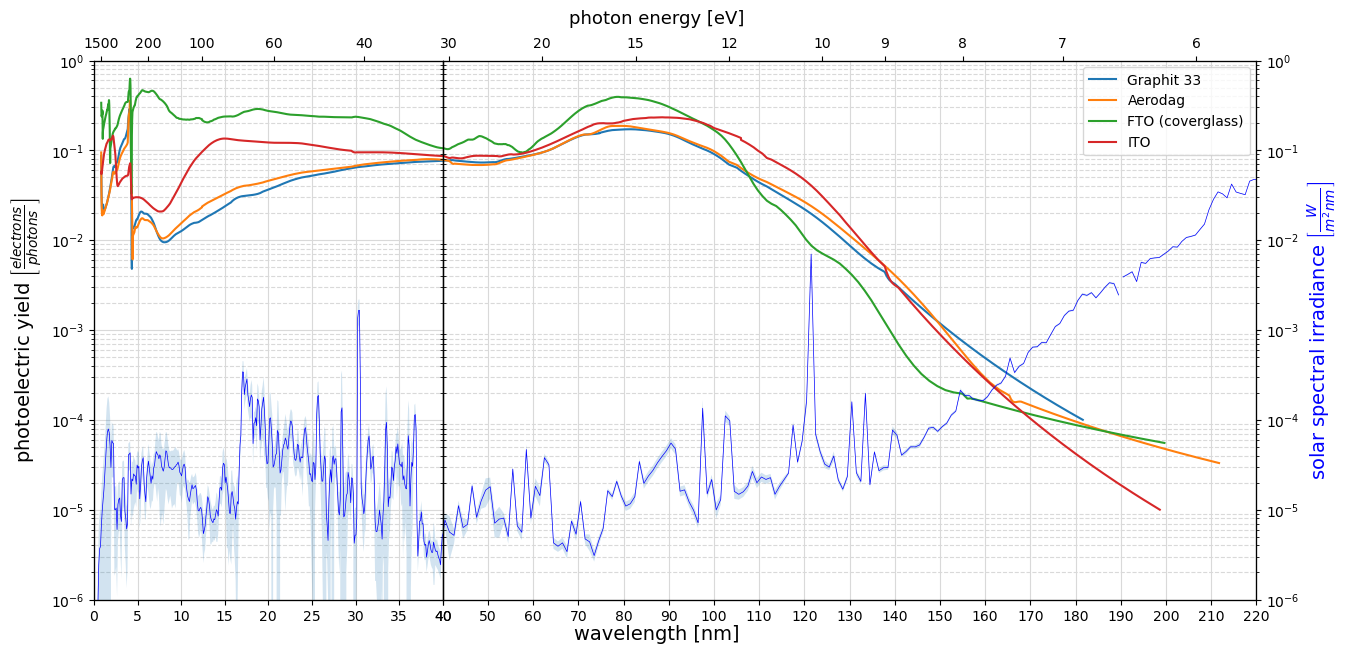

In [305]:
import matplotlib.gridspec as gridspec

plt.figure(figsize = (15,7),dpi=100)
gs = gridspec.GridSpec(1, 10)
gs.update(wspace=0.0, hspace=0.00) # set the spacing between axes. 

marker='.'
markersize=1
linewidth = 0.5
linestyle='none'
alpha=0.2
joinstyle='round'

ax1 = plt.subplot(gs[0,:3])
ax2 = plt.subplot(gs[0,3:])

ax3 = ax1.twinx()
ax3.plot(wavelength,irradiance,color='blue',linewidth=0.5,label='Solar\nIrradiance')
ax3.fill_between(wavelength, irradiance+irr_stdev, irradiance-irr_stdev, alpha=alpha, joinstyle=joinstyle)

ax4 = ax2.twinx()
ax4.plot(wavelength,irradiance,color='blue',linewidth=0.5,label='Solar\nIrradiance')
ax4.fill_between(wavelength, irradiance+irr_stdev, irradiance-irr_stdev, alpha=alpha, joinstyle=joinstyle)

ax1.plot(convert_eV_to_nm(Graphite_E_NEW),signal.savgol_filter(Graphite_TEY_NEW,15,3),'-',markersize=1)
ax2.plot(convert_eV_to_nm(Graphite_E_NEW),signal.savgol_filter(Graphite_TEY_NEW,15,3),'-',markersize=1,label='Graphit 33')

ax1.plot(convert_eV_to_nm(Aerodag_E_NEW),signal.savgol_filter(Aerodag_TEY_NEW,15,3),'-',markersize=1)
ax2.plot(convert_eV_to_nm(Aerodag_E_NEW),signal.savgol_filter(Aerodag_TEY_NEW,15,3),'-',markersize=1,label='Aerodag')

ax1.plot(convert_eV_to_nm(Coverglass_E_NEW),signal.savgol_filter(Coverglass_TEY_NEW,15,3),'-',markersize=1)
ax2.plot(convert_eV_to_nm(Coverglass_E_NEW),signal.savgol_filter(Coverglass_TEY_NEW,15,3),'-',markersize=1,label='FTO (coverglass)')

ax1.plot(convert_eV_to_nm(ITO_E_NEW),signal.savgol_filter(ITO_TEY_NEW,15,3),'-',markersize=1)
ax2.plot(convert_eV_to_nm(ITO_E_NEW),signal.savgol_filter(ITO_TEY_NEW,15,3),'-',markersize=1,label='ITO')

x_stop = 220
ax1.set_xlim(0,40)
ax2.set_xlim(40,x_stop)

ax1.set_ylim([1e-6,1])
ax2.set_ylim([1e-6,1])
ax3.set_ylim([1e-6,1])
ax4.set_ylim([1e-6,1])
ax1.set_yscale("log")
ax2.set_yscale("log")
ax3.set_yscale('log')
ax4.set_yscale('log')

plt.figtext(0.5, 0.06, 'wavelength [nm]', ha='center', va='center',size=14)
plt.figtext(0.5, 0.94, 'photon energy [eV]', ha='center', va='center',size=13)
ax1.set_ylabel(r"photoelectric yield $\left[\frac{electrons}{photons}\right]$",size=14)
ax1.grid(which = 'major', linestyle='-',color='0.85')
ax1.grid(which = 'minor', linestyle='--', color='0.85')

ax2.grid(which = 'major', linestyle='-',color='0.85')
ax2.grid(which = 'minor', linestyle='--', color='0.85')
ax2.set_xticks(np.arange(40,x_stop+1,10))
ax2.set_yscale('log')

ax2.set_yticks([])
ax3.set_yticks([])

ax6 = ax2.twiny()
new_eV_ticks=[6,7,8,9,10,12,15,20,30]
new_tick_locations = np.array(convert_eV_to_nm(new_eV_ticks))
ax6.set_xlim(ax2.get_xlim())
ax6.set_xticks(new_tick_locations)
ax6.set_xticklabels(new_eV_ticks)

ax5 = ax1.twiny()
new_eV_ticks=[40,60,100,200,1500]
new_tick_locations = np.array(convert_eV_to_nm(new_eV_ticks))
ax5.set_xlim(ax1.get_xlim())
ax5.set_xticks(new_tick_locations)
ax5.set_xticklabels(new_eV_ticks)

ax2.legend()

ax4.set_ylabel(r"solar spectral irradiance $\left[\frac{W}{m^2 nm}\right]$",color='blue',size=14)

plt.savefig('plots/non-metals_ion_threshs.png', bbox_inches='tight', dpi=300)

# Comparison (#2) of smoothened curves with the original ones:

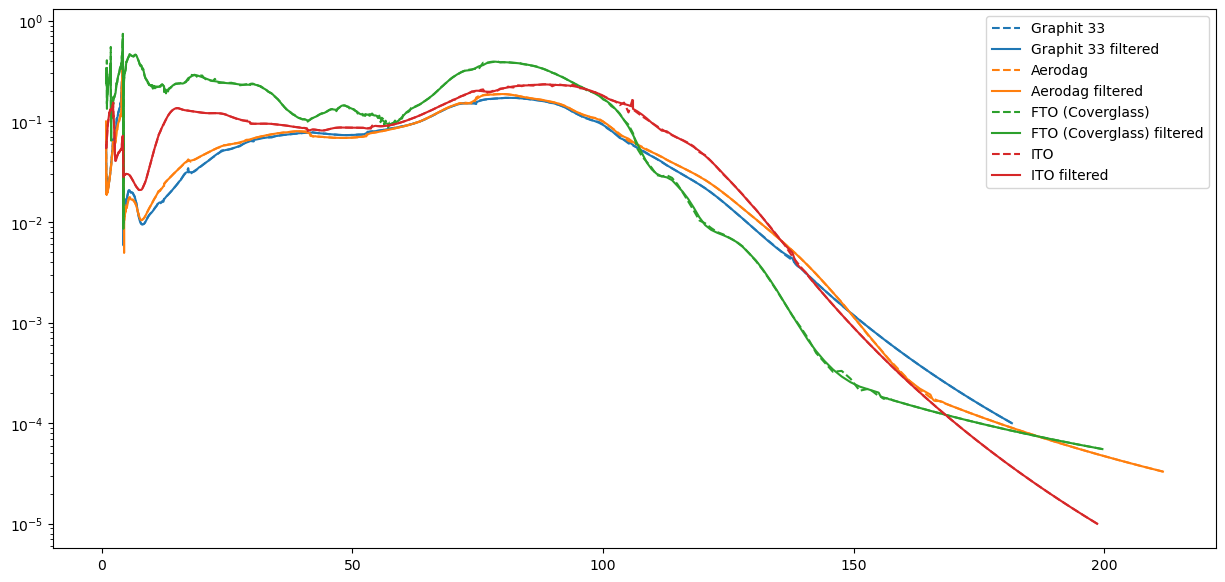

In [306]:

plt.figure(figsize = (15,7),dpi=100)
plt.plot(convert_eV_to_nm(Graphite_E_NEW),Graphite_TEY_NEW,'--',color='tab:blue',label='Graphit 33')
plt.plot(convert_eV_to_nm(Graphite_E_NEW),signal.savgol_filter(Graphite_TEY_NEW,17,5),'-',color='tab:blue',label='Graphit 33 filtered')

plt.plot(convert_eV_to_nm(Aerodag_E_NEW),Aerodag_TEY_NEW,'--',color='tab:orange',label='Aerodag')
plt.plot(convert_eV_to_nm(Aerodag_E_NEW),signal.savgol_filter(Aerodag_TEY_NEW,17,5),'-',color='tab:orange',label='Aerodag filtered')

plt.plot(convert_eV_to_nm(Coverglass_E_NEW),Coverglass_TEY_NEW,'--',color='tab:green',label='FTO (Coverglass)')
plt.plot(convert_eV_to_nm(Coverglass_E_NEW),signal.savgol_filter(Coverglass_TEY_NEW,17,5),'-',color='tab:green',label='FTO (Coverglass) filtered')

plt.plot(convert_eV_to_nm(ITO_E_NEW),ITO_TEY_NEW,'--',color='tab:red',label='ITO')
plt.plot(convert_eV_to_nm(ITO_E_NEW),signal.savgol_filter(ITO_TEY_NEW,17,5),'-',color='tab:red',label='ITO filtered')

plt.yscale('log')
plt.legend()

# Summary:

In [403]:
d = {'sample': ["Au","Ag", "Mg Alloy","Ti","ITO","Coverglass (FTO)", "Aerodag","Graphit 33"],
     'ionization [eV]': [Au_ion_thresh, Ag_ion_thresh,Mg_alloy_ion_thresh,Ti_ion_thresh,ITO_ion_thresh,Coverglass_ion_thresh,Aerodag_ion_thresh, Graphite_ion_thresh],
     r'J [uA/m^2]':[Au_J,Ag_J,Mg_alloy_J,Ti_J,ITO_J,Coverglass_J,Aerodag_J,Graphite_J]
     }
df = pd.DataFrame(data=d)
df.round({'ionization [eV]': 0})
df

,sample,ionization [eV],J [uA/m^2]
0,Au,6.08,41.00
1,Ag,5.81,51.02
2,Mg Alloy,5.28,157.64
3,Ti,5.96,49.95
4,ITO,6.24,52.73
5,Coverglass (FTO),6.21,36.38
6,Aerodag,5.86,34.38
7,Graphit 33,6.83,28.66
